In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

%matplotlib inline

In [2]:
import os

import config
from scenario import *
from tileset import *

scenarios = []
scenarios += process_scenarios(os.path.join(config.STARCRAFT_ROOT, 'Maps'))
for directory in config.MAP_DIRECTORIES:
    scenarios += process_scenarios(directory)

jungle_scenarios = [x for x in scenarios if x.tileset == Tileset.JUNGLE]

len(jungle_scenarios)

224

# Нормализация на данни

В предишни тетрадки видяхме, че плочките ни често се повтарят. Освен това има доста празни групи плочки ("група" са 16 на брой плочки с индекси от `16*k` до `16*k + 15`)

In [36]:
tile_to_unique_index = {}
unique_tiles = []

def normalize_tile(tile):
    tile_index = tile_to_unique_index[tile]
    return Tileset.JUNGLE.tiles[tile_index]

for tile in Tileset.JUNGLE.tiles:
    if tile not in tile_to_unique_index:
        unique_tiles.append(tile)
        tile_to_unique_index[tile] = 16 * tile.group_id + tile.group_offset

len(tile_to_unique_index)

3881

In [37]:
tile_group_to_normalized_group = {}

def normalize_tile_group(tile):
    return tile_group_to_normalized_group[normalize_tile(tile).group_id]

for tile in unique_tiles:
    if tile.group_id not in tile_group_to_normalized_group:
        tile_group_to_normalized_group[tile.group_id] = len(tile_group_to_normalized_group)

len(tile_group_to_normalized_group)

1051

# Построяване на `pandas.DataFrame`

Ще превърнем данните от картите във feature-и.

За всяка плочка във всяка карта ще разглеждаме тези в ляво и над нея. По тях ще се опитваме да предвиждаме нашата плочка.

Ще използваме полетата `buildable`, `is_empty`, `is_doodad` от горната и от лявата плочки. Освен това ще добавим `walkable`, `height`, `blocks_view`

In [238]:
def scenario_data(scenarios):
    for scenario in scenarios:
        tiles = scenario.tiles
        for i in range(tiles.shape[0]):
            for j in range(tiles.shape[1]):
                if j == 0:
                    left_tile = Tileset.JUNGLE.tiles[0]
                else:
                    left_tile = tiles[i, j - 1]

                if i == 0:
                    top_tile = Tileset.JUNGLE.tiles[0]
                else:
                    top_tile = tiles[i - 1, j]

                tile = tiles[i, j]

                yield [
                    normalize_tile_group(top_tile),
                    top_tile.group_offset,
                    top_tile.buildable,
                    top_tile.is_empty,
                    top_tile.is_doodad,
                    top_tile.minitiles[0, 0].walkable,
                    top_tile.minitiles[0, 1].walkable,
                    top_tile.minitiles[0, 2].walkable,
                    top_tile.minitiles[0, 3].walkable,
                    top_tile.minitiles[1, 0].walkable,
                    top_tile.minitiles[1, 1].walkable,
                    top_tile.minitiles[1, 2].walkable,
                    top_tile.minitiles[1, 3].walkable,
                    top_tile.minitiles[2, 0].walkable,
                    top_tile.minitiles[2, 1].walkable,
                    top_tile.minitiles[2, 2].walkable,
                    top_tile.minitiles[2, 3].walkable,
                    top_tile.minitiles[3, 0].walkable,
                    top_tile.minitiles[3, 1].walkable,
                    top_tile.minitiles[3, 2].walkable,
                    top_tile.minitiles[3, 3].walkable,
                    top_tile.minitiles[0, 0].height,
                    top_tile.minitiles[0, 1].height,
                    top_tile.minitiles[0, 2].height,
                    top_tile.minitiles[0, 3].height,
                    top_tile.minitiles[1, 0].height,
                    top_tile.minitiles[1, 1].height,
                    top_tile.minitiles[1, 2].height,
                    top_tile.minitiles[1, 3].height,
                    top_tile.minitiles[2, 0].height,
                    top_tile.minitiles[2, 1].height,
                    top_tile.minitiles[2, 2].height,
                    top_tile.minitiles[2, 3].height,
                    top_tile.minitiles[3, 0].height,
                    top_tile.minitiles[3, 1].height,
                    top_tile.minitiles[3, 2].height,
                    top_tile.minitiles[3, 3].height,
                    top_tile.minitiles[0, 0].blocks_view,
                    top_tile.minitiles[0, 1].blocks_view,
                    top_tile.minitiles[0, 2].blocks_view,
                    top_tile.minitiles[0, 3].blocks_view,
                    top_tile.minitiles[1, 0].blocks_view,
                    top_tile.minitiles[1, 1].blocks_view,
                    top_tile.minitiles[1, 2].blocks_view,
                    top_tile.minitiles[1, 3].blocks_view,
                    top_tile.minitiles[2, 0].blocks_view,
                    top_tile.minitiles[2, 1].blocks_view,
                    top_tile.minitiles[2, 2].blocks_view,
                    top_tile.minitiles[2, 3].blocks_view,
                    top_tile.minitiles[3, 0].blocks_view,
                    top_tile.minitiles[3, 1].blocks_view,
                    top_tile.minitiles[3, 2].blocks_view,
                    top_tile.minitiles[3, 3].blocks_view,
                    top_tile.minitiles[0, 0].ramp,
                    top_tile.minitiles[0, 1].ramp,
                    top_tile.minitiles[0, 2].ramp,
                    top_tile.minitiles[0, 3].ramp,
                    top_tile.minitiles[1, 0].ramp,
                    top_tile.minitiles[1, 1].ramp,
                    top_tile.minitiles[1, 2].ramp,
                    top_tile.minitiles[1, 3].ramp,
                    top_tile.minitiles[2, 0].ramp,
                    top_tile.minitiles[2, 1].ramp,
                    top_tile.minitiles[2, 2].ramp,
                    top_tile.minitiles[2, 3].ramp,
                    top_tile.minitiles[3, 0].ramp,
                    top_tile.minitiles[3, 1].ramp,
                    top_tile.minitiles[3, 2].ramp,
                    top_tile.minitiles[3, 3].ramp,
                    normalize_tile_group(left_tile),
                    left_tile.group_offset,
                    left_tile.buildable,
                    left_tile.is_empty,
                    left_tile.is_doodad,
                    left_tile.minitiles[0, 0].walkable,
                    left_tile.minitiles[0, 1].walkable,
                    left_tile.minitiles[0, 2].walkable,
                    left_tile.minitiles[0, 3].walkable,
                    left_tile.minitiles[1, 0].walkable,
                    left_tile.minitiles[1, 1].walkable,
                    left_tile.minitiles[1, 2].walkable,
                    left_tile.minitiles[1, 3].walkable,
                    left_tile.minitiles[2, 0].walkable,
                    left_tile.minitiles[2, 1].walkable,
                    left_tile.minitiles[2, 2].walkable,
                    left_tile.minitiles[2, 3].walkable,
                    left_tile.minitiles[3, 0].walkable,
                    left_tile.minitiles[3, 1].walkable,
                    left_tile.minitiles[3, 2].walkable,
                    left_tile.minitiles[3, 3].walkable,
                    left_tile.minitiles[0, 0].height,
                    left_tile.minitiles[0, 1].height,
                    left_tile.minitiles[0, 2].height,
                    left_tile.minitiles[0, 3].height,
                    left_tile.minitiles[1, 0].height,
                    left_tile.minitiles[1, 1].height,
                    left_tile.minitiles[1, 2].height,
                    left_tile.minitiles[1, 3].height,
                    left_tile.minitiles[2, 0].height,
                    left_tile.minitiles[2, 1].height,
                    left_tile.minitiles[2, 2].height,
                    left_tile.minitiles[2, 3].height,
                    left_tile.minitiles[3, 0].height,
                    left_tile.minitiles[3, 1].height,
                    left_tile.minitiles[3, 2].height,
                    left_tile.minitiles[3, 3].height,
                    left_tile.minitiles[0, 0].blocks_view,
                    left_tile.minitiles[0, 1].blocks_view,
                    left_tile.minitiles[0, 2].blocks_view,
                    left_tile.minitiles[0, 3].blocks_view,
                    left_tile.minitiles[1, 0].blocks_view,
                    left_tile.minitiles[1, 1].blocks_view,
                    left_tile.minitiles[1, 2].blocks_view,
                    left_tile.minitiles[1, 3].blocks_view,
                    left_tile.minitiles[2, 0].blocks_view,
                    left_tile.minitiles[2, 1].blocks_view,
                    left_tile.minitiles[2, 2].blocks_view,
                    left_tile.minitiles[2, 3].blocks_view,
                    left_tile.minitiles[3, 0].blocks_view,
                    left_tile.minitiles[3, 1].blocks_view,
                    left_tile.minitiles[3, 2].blocks_view,
                    left_tile.minitiles[3, 3].blocks_view,
                    left_tile.minitiles[0, 0].ramp,
                    left_tile.minitiles[0, 1].ramp,
                    left_tile.minitiles[0, 2].ramp,
                    left_tile.minitiles[0, 3].ramp,
                    left_tile.minitiles[1, 0].ramp,
                    left_tile.minitiles[1, 1].ramp,
                    left_tile.minitiles[1, 2].ramp,
                    left_tile.minitiles[1, 3].ramp,
                    left_tile.minitiles[2, 0].ramp,
                    left_tile.minitiles[2, 1].ramp,
                    left_tile.minitiles[2, 2].ramp,
                    left_tile.minitiles[2, 3].ramp,
                    left_tile.minitiles[3, 0].ramp,
                    left_tile.minitiles[3, 1].ramp,
                    left_tile.minitiles[3, 2].ramp,
                    left_tile.minitiles[3, 3].ramp,
                    normalize_tile_group(tile),
                    tile.group_offset,
                ]

In [239]:
def to_data_frame(scenarios):
    return pd.DataFrame(scenario_data(scenarios), columns = [
        'top_tile_group_id', 'top_tile_group_offset', 'top_is_buildable', 'top_is_empty', 'top_is_doodad',
        'top_minitile_00_walkable', 'top_minitile_01_walkable', 'top_minitile_02_walkable', 'top_minitile_03_walkable',
        'top_minitile_10_walkable', 'top_minitile_11_walkable', 'top_minitile_12_walkable', 'top_minitile_13_walkable',
        'top_minitile_20_walkable', 'top_minitile_21_walkable', 'top_minitile_22_walkable', 'top_minitile_23_walkable',
        'top_minitile_30_walkable', 'top_minitile_31_walkable', 'top_minitile_32_walkable', 'top_minitile_33_walkable',
        'top_minitile_00_height', 'top_minitile_01_height', 'top_minitile_02_height', 'top_minitile_03_height',
        'top_minitile_10_height', 'top_minitile_11_height', 'top_minitile_12_height', 'top_minitile_13_height',
        'top_minitile_20_height', 'top_minitile_21_height', 'top_minitile_22_height', 'top_minitile_23_height',
        'top_minitile_30_height', 'top_minitile_31_height', 'top_minitile_32_height', 'top_minitile_33_height',
        'top_minitile_00_blocks_view', 'top_minitile_01_blocks_view', 'top_minitile_02_blocks_view', 'top_minitile_03_blocks_view',
        'top_minitile_10_blocks_view', 'top_minitile_11_blocks_view', 'top_minitile_12_blocks_view', 'top_minitile_13_blocks_view',
        'top_minitile_20_blocks_view', 'top_minitile_21_blocks_view', 'top_minitile_22_blocks_view', 'top_minitile_23_blocks_view',
        'top_minitile_30_blocks_view', 'top_minitile_31_blocks_view', 'top_minitile_32_blocks_view', 'top_minitile_33_blocks_view',
        'top_minitile_00_ramp', 'top_minitile_01_ramp', 'top_minitile_02_ramp', 'top_minitile_03_ramp',
        'top_minitile_10_ramp', 'top_minitile_11_ramp', 'top_minitile_12_ramp', 'top_minitile_13_ramp',
        'top_minitile_20_ramp', 'top_minitile_21_ramp', 'top_minitile_22_ramp', 'top_minitile_23_ramp',
        'top_minitile_30_ramp', 'top_minitile_31_ramp', 'top_minitile_32_ramp', 'top_minitile_33_ramp',
        'left_tile_group_id', 'left_tile_group_offset', 'left_is_buildable', 'left_is_empty', 'left_is_doodad',
        'left_minitile_00_walkable', 'left_minitile_01_walkable', 'left_minitile_02_walkable', 'left_minitile_03_walkable',
        'left_minitile_10_walkable', 'left_minitile_11_walkable', 'left_minitile_12_walkable', 'left_minitile_13_walkable',
        'left_minitile_20_walkable', 'left_minitile_21_walkable', 'left_minitile_22_walkable', 'left_minitile_23_walkable',
        'left_minitile_30_walkable', 'left_minitile_31_walkable', 'left_minitile_32_walkable', 'left_minitile_33_walkable',
        'left_minitile_00_height', 'left_minitile_01_height', 'left_minitile_02_height', 'left_minitile_03_height',
        'left_minitile_10_height', 'left_minitile_11_height', 'left_minitile_12_height', 'left_minitile_13_height',
        'left_minitile_20_height', 'left_minitile_21_height', 'left_minitile_22_height', 'left_minitile_23_height',
        'left_minitile_30_height', 'left_minitile_31_height', 'left_minitile_32_height', 'left_minitile_33_height',
        'left_minitile_00_blocks_view', 'left_minitile_01_blocks_view', 'left_minitile_02_blocks_view', 'left_minitile_03_blocks_view',
        'left_minitile_10_blocks_view', 'left_minitile_11_blocks_view', 'left_minitile_12_blocks_view', 'left_minitile_13_blocks_view',
        'left_minitile_20_blocks_view', 'left_minitile_21_blocks_view', 'left_minitile_22_blocks_view', 'left_minitile_23_blocks_view',
        'left_minitile_30_blocks_view', 'left_minitile_31_blocks_view', 'left_minitile_32_blocks_view', 'left_minitile_33_blocks_view',
        'left_minitile_00_ramp', 'left_minitile_01_ramp', 'left_minitile_02_ramp', 'left_minitile_03_ramp',
        'left_minitile_10_ramp', 'left_minitile_11_ramp', 'left_minitile_12_ramp', 'left_minitile_13_ramp',
        'left_minitile_20_ramp', 'left_minitile_21_ramp', 'left_minitile_22_ramp', 'left_minitile_23_ramp',
        'left_minitile_30_ramp', 'left_minitile_31_ramp', 'left_minitile_32_ramp', 'left_minitile_33_ramp',
        'tile_group_id',
        'tile_group_offset',
    ])

# Голям dataset

Това е големият ни dataset:

In [ ]:
# big_dataset = to_data_frame(jungle_scenarios)
# big_dataset.to_csv('classical-machine-learning-tiles-big.csv')

Редовете в него биха били:

In [70]:
sum(x.width * x.height for x in jungle_scenarios)

4938752

Няма да бързаме да работим с него. Нека пробваме други неща за сега...

# Малък dataset

Броят карти в него е:

In [71]:
len([x for x in jungle_scenarios if x.width == 64 and x.height == 64])

12

In [240]:
small_dataset = to_data_frame(x for x in jungle_scenarios if x.width == 64 and x.height == 64)
small_dataset.to_csv('classical-machine-learning-tiles-small.csv')

CSV файлът се получи 40 MB. Да погледнем малко повече неща за данните:

In [241]:
small_dataset.columns

Index(['top_tile_group_id', 'top_tile_group_offset', 'top_is_buildable',
       'top_is_empty', 'top_is_doodad', 'top_minitile_00_walkable',
       'top_minitile_01_walkable', 'top_minitile_02_walkable',
       'top_minitile_03_walkable', 'top_minitile_10_walkable',
       ...
       'left_minitile_20_ramp', 'left_minitile_21_ramp',
       'left_minitile_22_ramp', 'left_minitile_23_ramp',
       'left_minitile_30_ramp', 'left_minitile_31_ramp',
       'left_minitile_32_ramp', 'left_minitile_33_ramp', 'tile_group_id',
       'tile_group_offset'],
      dtype='object', length=140)

In [242]:
small_dataset.shape

(49152, 140)

In [243]:
small_dataset.head()

,top_tile_group_id,top_tile_group_offset,top_is_buildable,top_is_empty,top_is_doodad,top_minitile_00_walkable,top_minitile_01_walkable,top_minitile_02_walkable,top_minitile_03_walkable,top_minitile_10_walkable,...,left_minitile_20_ramp,left_minitile_21_ramp,left_minitile_22_ramp,left_minitile_23_ramp,left_minitile_30_ramp,left_minitile_31_ramp,left_minitile_32_ramp,left_minitile_33_ramp,tile_group_id,tile_group_offset
0,0,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,22,5
1,0,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,23,5
2,0,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,22,4
3,0,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,23,4
4,0,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,22,5


In [244]:
small_dataset.dtypes

top_tile_group_id                 int64
top_tile_group_offset             int64
top_is_buildable                   bool
top_is_empty                       bool
top_is_doodad                      bool
top_minitile_00_walkable           bool
top_minitile_01_walkable           bool
top_minitile_02_walkable           bool
top_minitile_03_walkable           bool
top_minitile_10_walkable           bool
top_minitile_11_walkable           bool
top_minitile_12_walkable           bool
top_minitile_13_walkable           bool
top_minitile_20_walkable           bool
top_minitile_21_walkable           bool
top_minitile_22_walkable           bool
top_minitile_23_walkable           bool
top_minitile_30_walkable           bool
top_minitile_31_walkable           bool
top_minitile_32_walkable           bool
top_minitile_33_walkable           bool
top_minitile_00_height          float64
top_minitile_01_height          float64
top_minitile_02_height          float64
top_minitile_03_height          float64


Нещата изглеждат добре. В предишни notebook-ове вече разглеждахме данните. Няма да се впускаме в изследване на самите колони. Особено при положение, че ние сме си ги генерирали.

# Разпределение на плочките

Нека разглеждаме групите плочки и колко често се срещат.

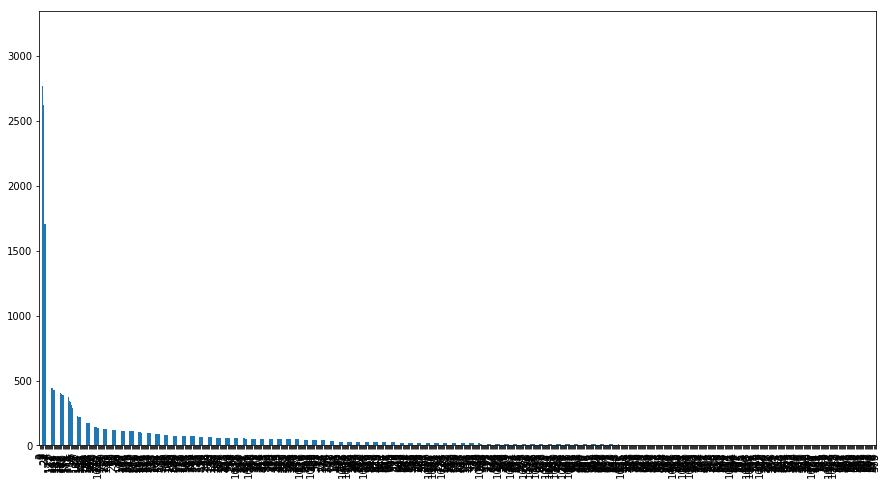

In [199]:
plt.figure(figsize=(15, 8))
small_dataset.tile_group_id.value_counts().plot(kind='bar');

Доста неравномерно разпределение. Нека видим първите 30 най-често срещани групи плочки:

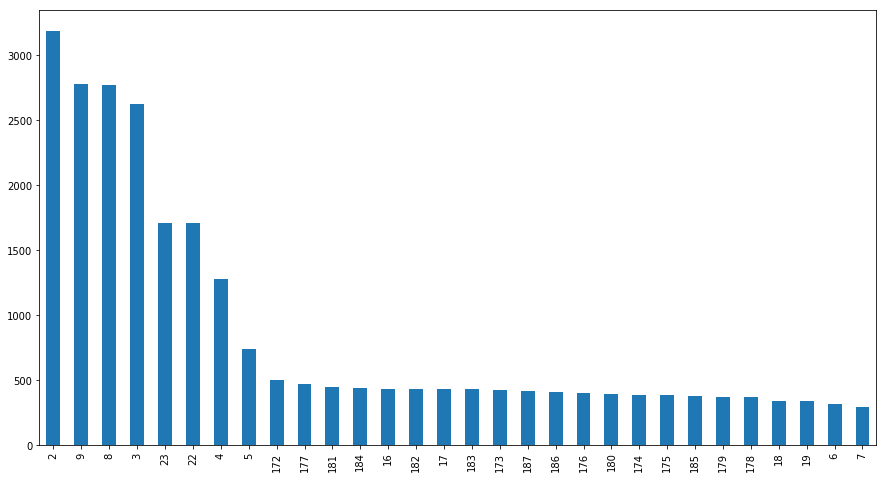

In [94]:
plt.figure(figsize=(15, 8))
small_dataset.tile_group_id.value_counts()[:30].plot(kind='bar');

In [98]:
sum(small_dataset.tile_group_id.value_counts()[:30])

25529

Общият брой групи плочки беше 1051. Общият брой редове в данните беше около 50000. Най-често срещаните 30 групи плочки представляват над половината срещания.

In [101]:
sum(small_dataset.tile_group_id.value_counts()[:5])

13062

А най-често срещаните 5 групи - над четвърт от срещанията.

Нека видим някой от най-често срещаните плочки (по групи):

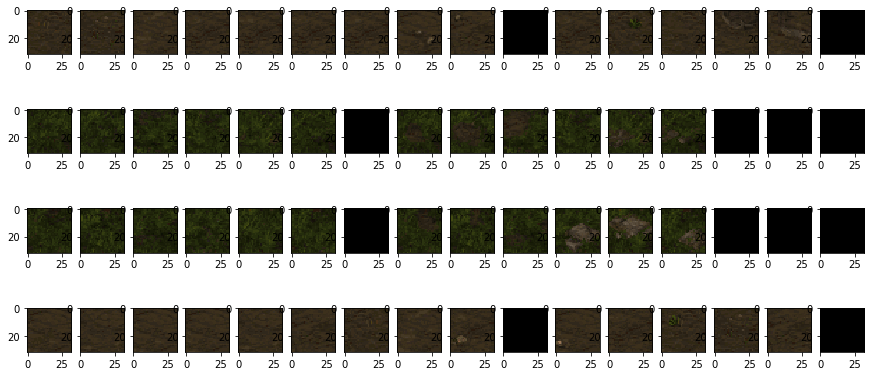

In [137]:
plt.figure(figsize=(15, 7))

most_common_groups = [2, 9, 8, 3]
for i, tile_group_id in enumerate(most_common_groups):
    for j in range(16):
        plt.subplot(len(most_common_groups), 16, 16 * i + j + 1)
        plt.imshow(Tileset.JUNGLE.tiles[16 * tile_group_id + j].graphics)

Трева и кал. Legit.

Най-често срещаната група е:

In [146]:
small_dataset.tile_group_id.value_counts()[:1]

2    3190
Name: tile_group_id, dtype: int64

И шансът да я срещнем е:

In [147]:
small_dataset.tile_group_id.value_counts()[:1].values[0] / len(small_dataset)

6.490071614583333

В данните ни има нещо напомнящо на [закона на Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law).

Това едва ли ще ни влезе в употреба. Но само няколко класа представляват голяма част от срещанията. Ще трябва да отчетем това, когато разглеждаме score-а на класификаторите.

# Класификатор с количествени данни

За feature-и ще използваме почти всичко, но ще изхърлим `group_id`/`group_offset` за горната и за лявата плочки, тъй като не са количествени променливи.

За етикети при класификацията ще използваме `group_id` за търсената плочка.

In [253]:
from sklearn.model_selection import train_test_split

x = small_dataset.drop([
    'top_tile_group_id', 'top_tile_group_offset',
    'left_tile_group_id', 'left_tile_group_offset',
    'tile_group_id', 'tile_group_offset',
], axis=1)

y = small_dataset['tile_group_id']

In [254]:
x.head()

,top_is_buildable,top_is_empty,top_is_doodad,top_minitile_00_walkable,top_minitile_01_walkable,top_minitile_02_walkable,top_minitile_03_walkable,top_minitile_10_walkable,top_minitile_11_walkable,top_minitile_12_walkable,...,left_minitile_12_ramp,left_minitile_13_ramp,left_minitile_20_ramp,left_minitile_21_ramp,left_minitile_22_ramp,left_minitile_23_ramp,left_minitile_30_ramp,left_minitile_31_ramp,left_minitile_32_ramp,left_minitile_33_ramp
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [255]:
y.head()

0    22
1    23
2    22
3    23
4    22
Name: tile_group_id, dtype: int64

In [256]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1337)

In [257]:
from sklearn.linear_model import RidgeClassifier

classifier = RidgeClassifier()
classifier.fit(x_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [258]:
print(classifier.score(x_train, y_train))
print(classifier.score(x_test, y_test))

0.19761827256944445
0.19514973958333334


Не е особено впечатляващо. Особено при положение, че ако за клас казваме "2", ще оцелваме 6.5% от случаите. Но поне не overfit-ваме.

In [259]:
classifier.coef_.shape

(727, 134)

Няма да бъде съвсем лесно разберем какво се случва с теглата, защото не работим с регресор, а с класификатор. И то класификатор с много класове. Нека все пак поразгледаме...

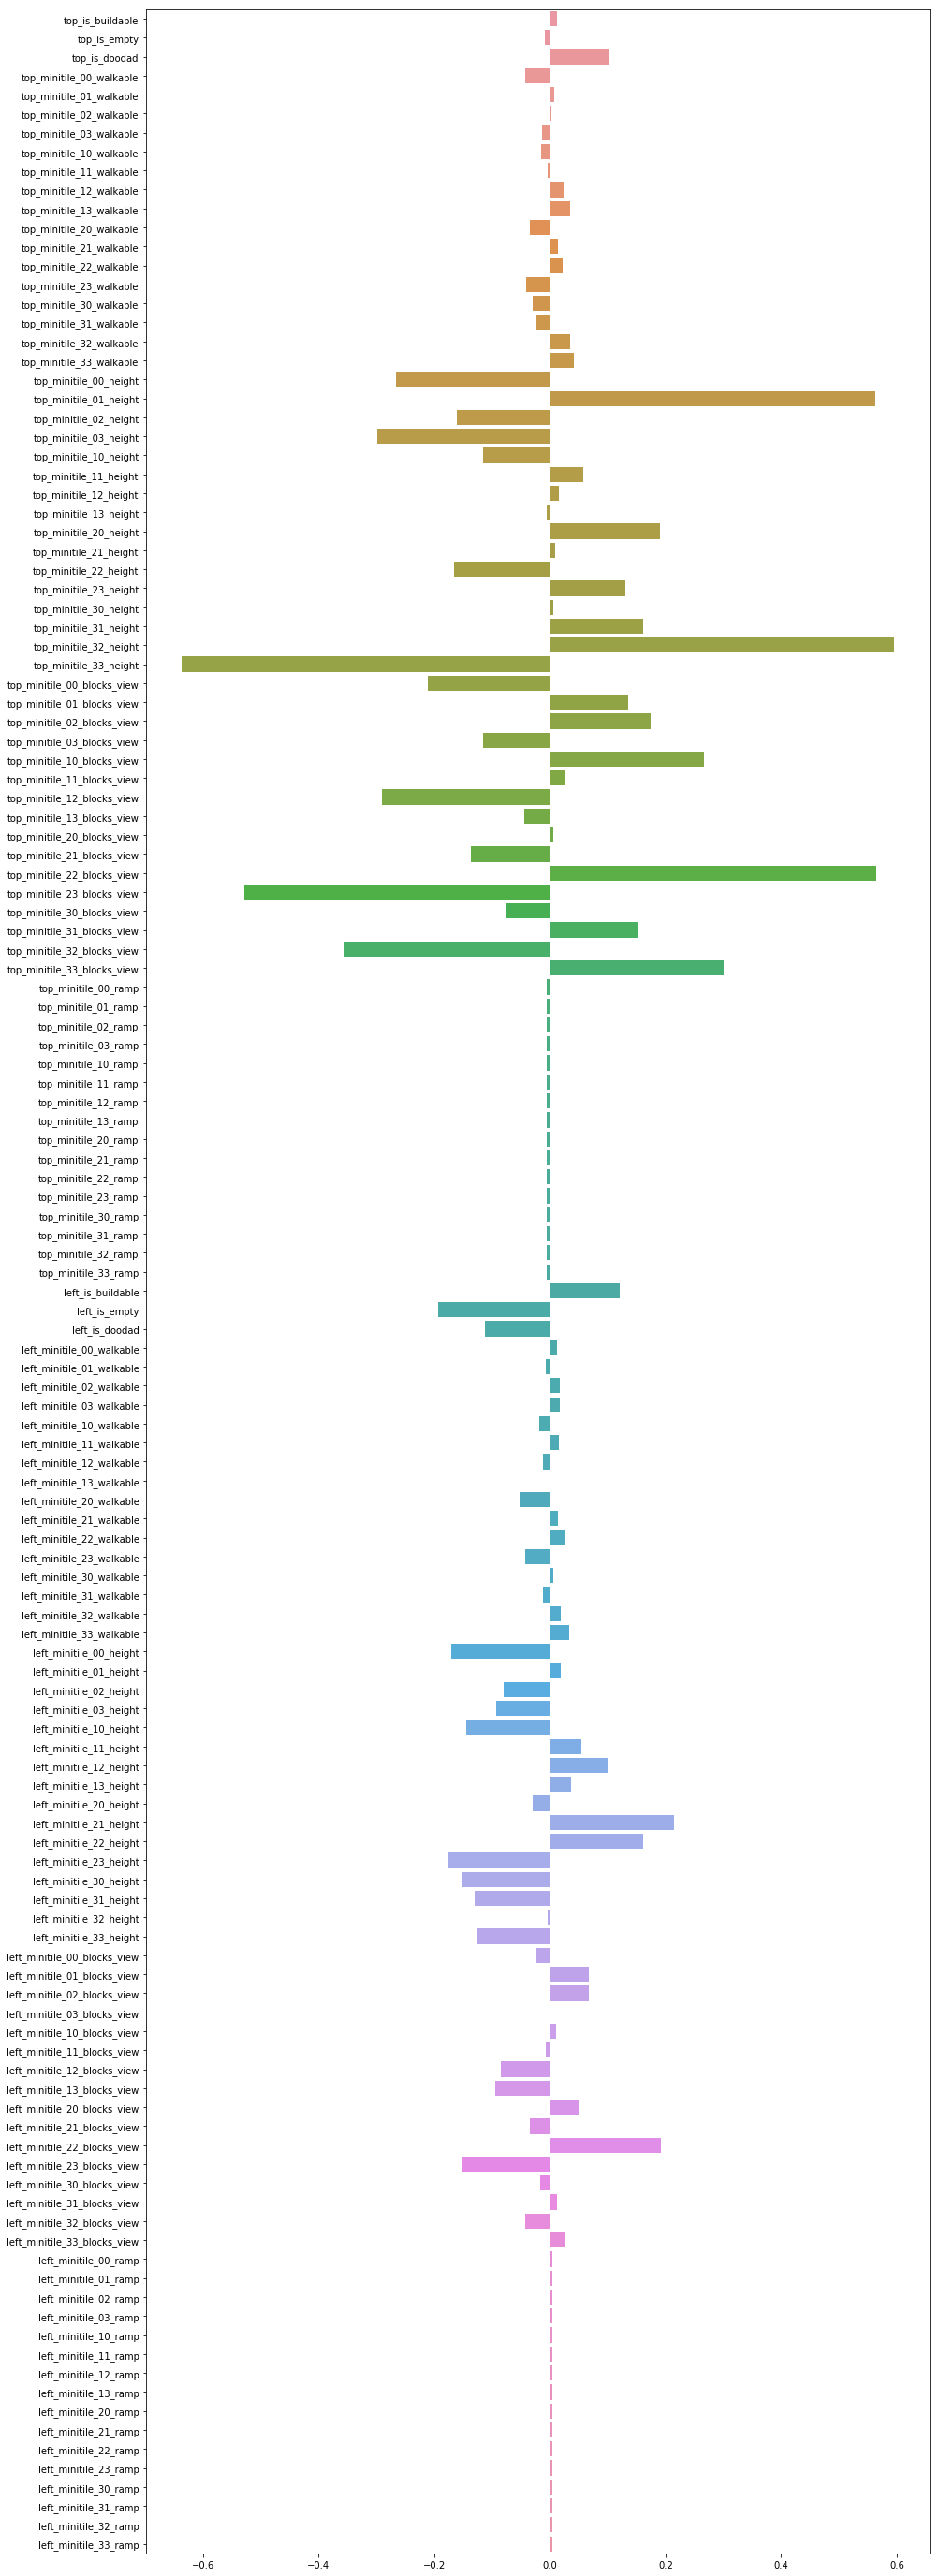

In [260]:
plt.figure(figsize=(15, 50))
barplot = sns.barplot(x=classifier.coef_[1], y=x.columns, orient='horizontal')

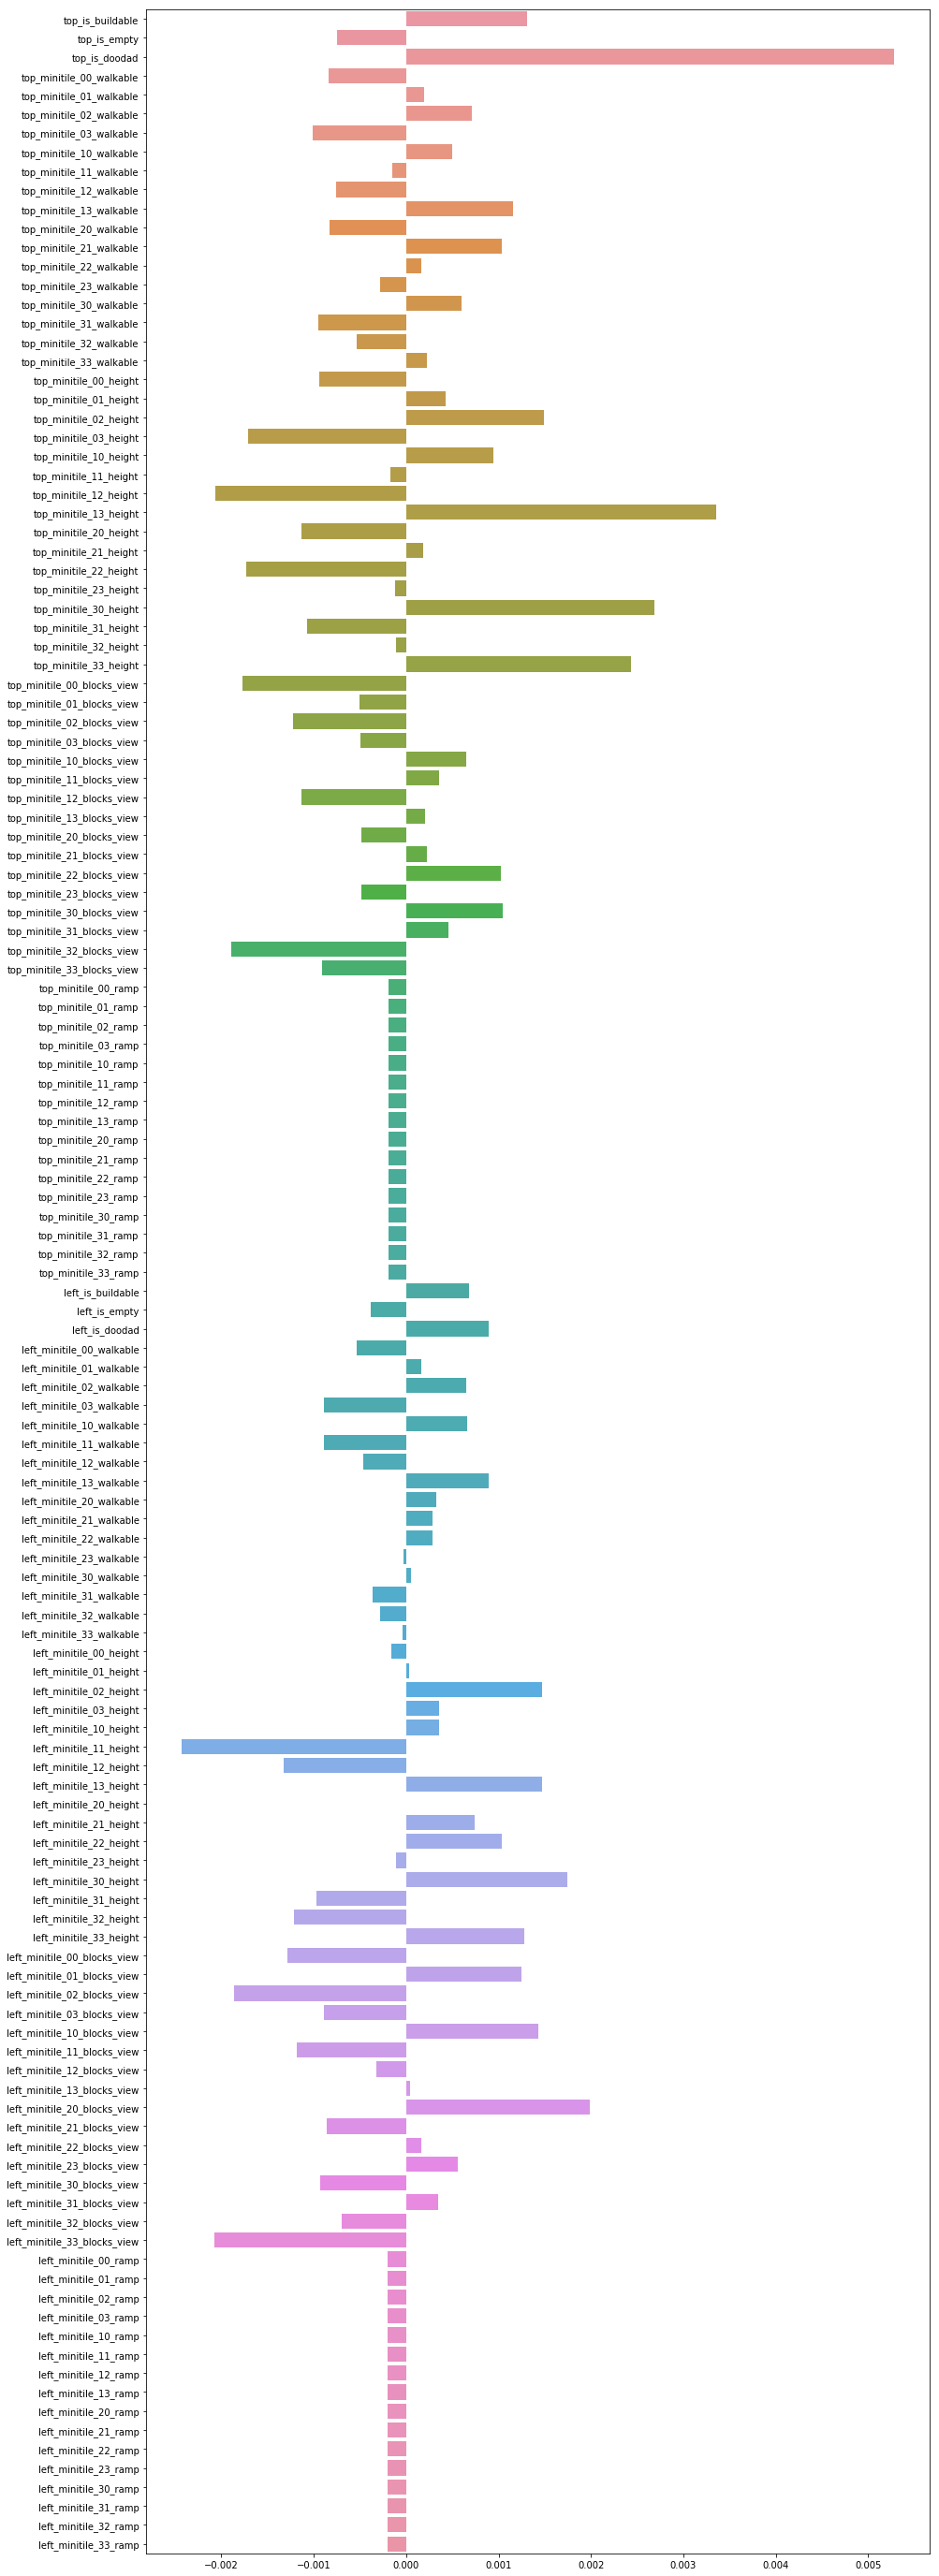

In [271]:
plt.figure(figsize=(15, 50))
barplot = sns.barplot(x=classifier.coef_[520], y=x.columns, orient='horizontal')

Интуитивно е, че миниплочките по краищата ще имат по-голямо тегло от тези в средата. Интуитивно, но невярно. Дори да има такава зависимост не се забелязва лесно.

От друга страна за някои класове някои feature-и нямат голямо значение (напр. `*_ramp`). Но пък се появяват с някакво тегло за други. Като цяло не изглежда да има feature, за което да кажем, че може да се изхвърли.

# Класификатор с категорийни данни за група плочки

Ще тренираме класификатор, използвайки `left_tile_group_id`/`top_tile_group_id`, прилагайки one hot encoding. Това се доближава повече до логиката, която е hard-code-ната в редактора на карти на StarCraft, който беше споменат в по-ранна тетрадка.

Очакваме по-добри резултати при това трениране.

In [270]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def one_hot_encode(dataset, column):
    values = dataset[column].values.reshape(-1, 1)
    onehot_encoded = OneHotEncoder(sparse = False).fit_transform(values)
    return pd.DataFrame(onehot_encoded)

left_encoded = one_hot_encode(small_dataset, 'left_tile_group_id')
top_encoded = one_hot_encode(small_dataset, 'top_tile_group_id')
one_hot_x = pd.concat([left_encoded, top_encoded], axis=1)

print(left_encoded.shape)
print(top_encoded.shape)
print(one_hot_x.shape)

C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

(49152, 742)
(49152, 742)
(49152, 1484)


In [274]:
x_train, x_test, y_train, y_test = train_test_split(one_hot_x, y, test_size=0.25, random_state=1337)

classifier2 = RidgeClassifier()
classifier2.fit(x_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [275]:
print(classifier2.score(x_train, y_train))
print(classifier2.score(x_test, y_test))

0.8439670138888888
0.8260904947916666


Това вече изглежда по-добре. Нека видим дали комбинацията от всички feature-и ще даде подобрение преди да се заиграваме с хиперпараметри и други алгоритми за класификация.

# Класификатор с всички данни

In [276]:
new_x = pd.concat([one_hot_x, x], axis=1)

In [278]:
new_x.shape

(49152, 1618)

In [277]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.25, random_state=1337)

classifier3 = RidgeClassifier()
classifier3.fit(x_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [279]:
print(classifier3.score(x_train, y_train))
print(classifier3.score(x_test, y_test))

0.8458116319444444
0.827392578125


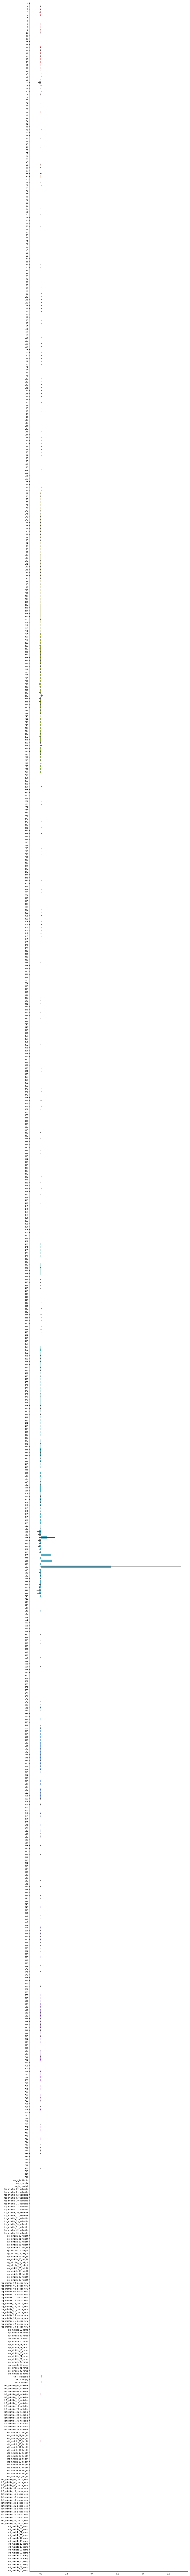

In [304]:
plt.figure(figsize=(15, 250))
barplot = sns.barplot(x=classifier3.coef_[520], y=new_x.columns, orient='horizontal')

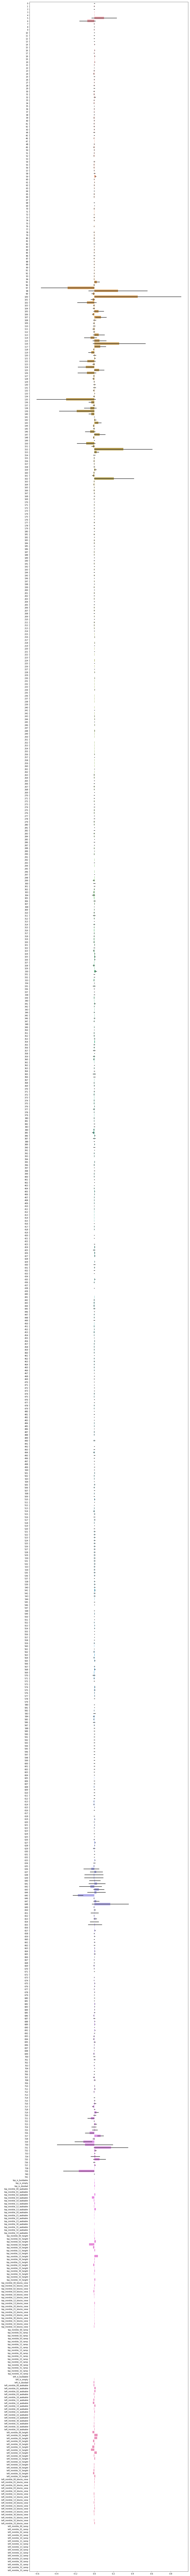

In [305]:
plt.figure(figsize=(15, 250))
barplot = sns.barplot(x=classifier3.coef_[100], y=new_x.columns, orient='horizontal')

След известно разглеждане на теглата, започва да изглежда, че няма много смисъл от всички тези feature-и. Изглежда групите на горната и лявата плочки са по-важни. Ще опитаме да тренираме само с тях.

Тук си заслужава да се отбележи, че в tileset-овете доста често се срещат дублиращи се плочки. Ние ги премахваме. А откриването на дублирания се прави на базата на feature-ите, които искаме да премхнем. Така че тази информация не изчезва [съвсем] безследно.


# Построяване на `pandas.DataFrame` - част 2

Ще приложим идеята за ползване единствено на групи плочки. Но ще опитаме да вкараме и номер на плочка в група.

In [5]:
import collections

tile_to_int = collections.defaultdict(lambda: len(tile_to_int))

def scenario_data(scenarios):
    for scenario in scenarios:
        tiles = scenario.tiles
        for i in range(tiles.shape[0]):
            for j in range(tiles.shape[1]):
                if j == 0:
                    left_tile = Tileset.JUNGLE.tiles[0]
                else:
                    left_tile = tiles[i, j - 1]

                if i == 0:
                    top_tile = Tileset.JUNGLE.tiles[0]
                else:
                    top_tile = tiles[i - 1, j]

                tile = tiles[i, j]

                yield [tile_to_int[top_tile], tile_to_int[left_tile], tile_to_int[tile]]

In [6]:
def to_data_frame(scenarios):
    return pd.DataFrame(scenario_data(scenarios), columns = ['top_tile', 'left_tile', 'tile'])

In [7]:
small_dataset_2 = to_data_frame(x for x in jungle_scenarios if x.width == 64 and x.height == 64)
small_dataset_2.to_csv('classical-machine-learning-tiles-small-2.csv')

In [18]:
def one_hot_encode_tile(dataset, column):
    values = dataset[column].values.reshape(-1, 1)
    onehot_encoded = OneHotEncoder(sparse = False).fit_transform(values)
    data_frame = pd.DataFrame(onehot_encoded)
    data_frame.columns = [str(column) + '_' + str(col_index) for col_index in data_frame.columns]
    return data_frame

simpler_x = pd.concat([
    one_hot_encode_tile(small_dataset_2, 'left_tile'),
    one_hot_encode_tile(small_dataset_2, 'top_tile'),
], axis=1)

simpler_y = small_dataset_2['tile']

simpler_x.head()

C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

,left_tile_0,left_tile_1,left_tile_2,left_tile_3,left_tile_4,left_tile_5,left_tile_6,left_tile_7,left_tile_8,left_tile_9,...,top_tile_2507,top_tile_2508,top_tile_2509,top_tile_2510,top_tile_2511,top_tile_2512,top_tile_2513,top_tile_2514,top_tile_2515,top_tile_2516
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Заради броят feature-и след one hot encoding, времето за трениране е **потресаващо** зле за RidgeClassifier. Въпреки, че RidgeClassifierCV е многонишков - това пак не помага да приключи за нормално време. Ще трябва да пропуснем...

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(simpler_x, simpler_y, test_size=0.25, random_state=1337)
#
#classifier4 = RidgeClassifierCV()
#classifier4.fit(x_train, y_train)

In [ ]:
#print(classifier4.score(x_train, y_train))
#print(classifier4.score(x_test, y_test))

## Дървета

Да опитаме да тренираме decision trees. Те нямат нужда от one hot encoding и ще се тренират значително по-бързо.

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree_x = small_dataset_2[['left_tile', 'top_tile']]
tree_y = small_dataset_2.tile
x_train, x_test, y_train, y_test = train_test_split(tree_x, tree_y, test_size=0.25, random_state=1337)

for max_depth in [10, 30, 50, 100]:
    for min_samples_split in [2, 3, 5, 10]:
        classifier5 = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        classifier5.fit(x_train, y_train)

        print('max_depth:', max_depth,
              'min_samples_split:', min_samples_split,
              'train:', classifier5.score(x_train, y_train),
              'test:', classifier5.score(x_test, y_test))

max_depth: 10 min_samples_split: 2 train: 0.2073025173611111 test: 0.194091796875
max_depth: 10 min_samples_split: 3 train: 0.2070855034722222 test: 0.194091796875
max_depth: 10 min_samples_split: 5 train: 0.2068413628472222 test: 0.194091796875
max_depth: 10 min_samples_split: 10 train: 0.20616319444444445 test: 0.19425455729166666
max_depth: 30 min_samples_split: 2 train: 0.7252332899305556 test: 0.555908203125
max_depth: 30 min_samples_split: 3 train: 0.7086046006944444 test: 0.5531412760416666
max_depth: 30 min_samples_split: 5 train: 0.681884765625 test: 0.5458984375
max_depth: 30 min_samples_split: 10 train: 0.6418999565972222 test: 0.5349934895833334
max_depth: 50 min_samples_split: 2 train: 0.821044921875 test: 0.5922037760416666
max_depth: 50 min_samples_split: 3 train: 0.7891438802083334 test: 0.5863444010416666
max_depth: 50 min_samples_split: 5 train: 0.7408854166666666 test: 0.5732421875
max_depth: 50 min_samples_split: 10 train: 0.6780056423611112 test: 0.55517578125
max_

In [12]:
from sklearn.tree import ExtraTreeClassifier

for max_depth in [30, 50, 100]:
    for min_samples_split in [2, 3, 5, 10]:
        classifier5 = ExtraTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        classifier5.fit(x_train, y_train)

        print('max_depth:', max_depth,
              'min_samples_split:', min_samples_split,
              'train:', classifier5.score(x_train, y_train),
              'test:', classifier5.score(x_test, y_test))

max_depth: 30 min_samples_split: 2 train: 0.821044921875 test: 0.54443359375
max_depth: 30 min_samples_split: 3 train: 0.7741156684027778 test: 0.5423990885416666
max_depth: 30 min_samples_split: 5 train: 0.7027994791666666 test: 0.5139973958333334
max_depth: 30 min_samples_split: 10 train: 0.6083170572916666 test: 0.4752604166666667
max_depth: 50 min_samples_split: 2 train: 0.8245985243055556 test: 0.556884765625
max_depth: 50 min_samples_split: 3 train: 0.7758246527777778 test: 0.542236328125
max_depth: 50 min_samples_split: 5 train: 0.704345703125 test: 0.5118815104166666
max_depth: 50 min_samples_split: 10 train: 0.6027018229166666 test: 0.4628092447916667
max_depth: 100 min_samples_split: 2 train: 0.8245985243055556 test: 0.5499674479166666
max_depth: 100 min_samples_split: 3 train: 0.7743598090277778 test: 0.5349934895833334
max_depth: 100 min_samples_split: 5 train: 0.7081163194444444 test: 0.521240234375
max_depth: 100 min_samples_split: 10 train: 0.6025119357638888 test: 0.464

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

for max_depth in [30, 50, 100]:
    for n_estimators in [10, 20]:
        classifier5 = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators)
        classifier5.fit(x_train, y_train)

        print('max_depth:', max_depth,
              'n_estimators :', n_estimators,
              'train:', classifier5.score(x_train, y_train),
              'test:', classifier5.score(x_test, y_test))

max_depth: 30 n_estimators : 10 train: 0.8245985243055556 test: 0.5594075520833334
max_depth: 30 n_estimators : 20 train: 0.8245985243055556 test: 0.5609537760416666
max_depth: 50 n_estimators : 10 train: 0.8245985243055556 test: 0.5651041666666666
max_depth: 50 n_estimators : 20 train: 0.8245985243055556 test: 0.5611165364583334
max_depth: 100 n_estimators : 10 train: 0.8245985243055556 test: 0.556640625
max_depth: 100 n_estimators : 20 train: 0.8245985243055556 test: 0.5611165364583334


In [14]:
from sklearn.ensemble import RandomForestClassifier

for max_depth in [30, 50, 100]:
    for n_estimators in [5, 10, 15]:
        classifier5 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
        classifier5.fit(x_train, y_train)

        print('max_depth:', max_depth,
              'n_estimators:', n_estimators,
              'train:', classifier5.score(x_train, y_train),
              'test:', classifier5.score(x_test, y_test))

max_depth: 30 n_estimators: 5 train: 0.7888454861111112 test: 0.550537109375
max_depth: 30 n_estimators: 10 train: 0.81201171875 test: 0.558837890625
max_depth: 30 n_estimators: 15 train: 0.8170301649305556 test: 0.5628255208333334
max_depth: 50 n_estimators: 5 train: 0.7978515625 test: 0.554443359375
max_depth: 50 n_estimators: 10 train: 0.815673828125 test: 0.5596516927083334
max_depth: 50 n_estimators: 15 train: 0.82080078125 test: 0.5611979166666666
max_depth: 100 n_estimators: 5 train: 0.796630859375 test: 0.547119140625
max_depth: 100 n_estimators: 10 train: 0.8150770399305556 test: 0.5592447916666666
max_depth: 100 n_estimators: 15 train: 0.820556640625 test: 0.56103515625


Всички overfit-ват доста. И изглежда, че с хиперпараметри няма да подобрим нещата. Може би имаме нужда от повече данни?

## Алтернативна репрезентация на данните

Ще направим два категорийни feature-а - тип и вариант. За нормалните плочки от терена типът ще отговаря на група плочки, а варианта - на индекса в групата плочки + 1. За "doodad" плочките типът ще е уникално число (независимо, че е в група с други плочки), а вариантът ще бъде 0.

Това ще ни позволи да one hot encode-нем тип и вариант поотделно, което ще доведе до значително по-малко feature-и.

За сега за етикет ще използваме единствено типа на търсената плочка (без варианта)

In [5]:
jungle_tiles = Tileset.JUNGLE.tiles
terrain_tiles = (tile for tile in jungle_tiles if not tile.is_doodad)
doodad_tiles = (tile for tile in jungle_tiles if tile.is_doodad)

groups = dict()
tile_features = dict()

for tile in terrain_tiles:
    if not tile.group_id in groups:
        groups[tile.group_id] = len(groups)
    tile_features[tile] = (groups[tile.group_id], tile.group_offset + 1)

group_count = len(groups)
del(groups)
for tile in doodad_tiles:
    group_count += 1
    tile_features[tile] = (group_count, 0)

def scenario_data(scenarios):
    for scenario in scenarios:
        for i in range(scenario.tiles.shape[0]):
            for j in range(scenario.tiles.shape[1]):
                left_tile = scenario.tiles[i, j - 1] if j != 0 else jungle_tiles[0]
                top_tile = scenario.tiles[i - 1, j] if i != 0 else jungle_tiles[0]
                tile = scenario.tiles[i, j]

                yield [*tile_features[top_tile], *tile_features[left_tile], *tile_features[tile]]

def to_data_frame(scenarios):
    return pd.DataFrame(scenario_data(scenarios), columns = [
        'top_tile_kind', 'top_tile_variant',
        'left_tile_kind', 'left_tile_variant',
        'tile_kind', 'tile_variant'
    ])

In [7]:
small_dataset_3 = to_data_frame(x for x in jungle_scenarios if x.width == 64 and x.height == 64)
small_dataset_3.shape

(49152, 6)

In [11]:
third_x = pd.concat([
    one_hot_encode_tile(small_dataset_3, 'top_tile_kind'),
    one_hot_encode_tile(small_dataset_3, 'top_tile_variant'),
    one_hot_encode_tile(small_dataset_3, 'left_tile_kind'),
    one_hot_encode_tile(small_dataset_3, 'left_tile_variant'),
], axis=1)

third_y = small_dataset_3.tile_kind

C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\dev\work\random-map\model\env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

In [18]:
x_train, x_test, y_train, y_test = train_test_split(third_x, third_y, test_size=0.25, random_state=1337)

classifier6 = RidgeClassifier()
classifier6.fit(x_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [19]:
print(classifier6.score(x_train, y_train))
print(classifier6.score(x_test, y_test))

0.80322265625
0.7737630208333334


Резултатът е по-нисък от най-високия до момента. Но ни се наложи да променим етикетите в името на по-малко feature-и.

# Идеи за подобрения

- Вместо one hot encoding да се ползват embedding-и за плочките
- Изходът от този модел да служи за вход на 2D LSTM **или** Да се направи stacking на този модел и 2D LSTM
- Да predict-ваме както типа, така и варианта на плочка (вместо само типа)